In [9]:
!pip install captum

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [12]:
!pip install captum --upgrade

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from captum.attr import LRP, GuidedBackprop
import matplotlib.pyplot as plt
import numpy as np

Predicted: truck, True: truck


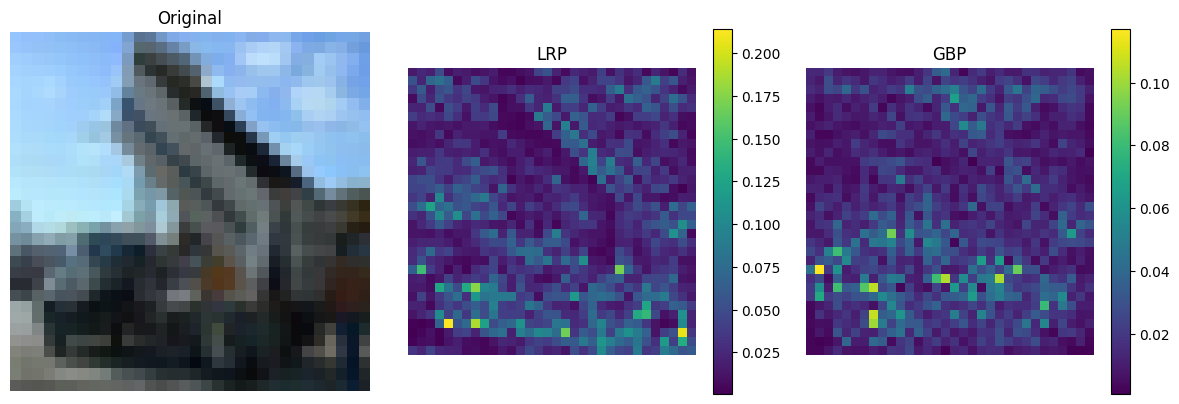

In [19]:
# Quick setup for CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
test_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a model using ModuleList and custom forward function to avoid Flatten
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32*8*8, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Manual flattening instead of nn.Flatten
        return self.classifier(x)

model = SimpleCNN()

# Train quickly
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Single-epoch training
model.train()
for imgs, labels in DataLoader(train_ds, batch_size=64, shuffle=True):
    optimizer.zero_grad()
    criterion(model(imgs), labels).backward()
    optimizer.step()

# Get a test image
model.eval()
for i, (img, label) in enumerate(DataLoader(test_ds, batch_size=1)):
    if i == 50:
        input_img, target = img, label
        break
input_img.requires_grad = True

# Get prediction and compute attributions
out = model(input_img)
pred = out.argmax(dim=1).item()
print(f"Predicted: {test_ds.classes[pred]}, True: {test_ds.classes[target.item()]}")

# Compute XAI attributions
lrp_attr = LRP(model).attribute(input_img, target=pred)
gbp_attr = GuidedBackprop(model).attribute(input_img, target=pred)

# Prepare for visualization
lrp_viz = np.abs(lrp_attr.squeeze().cpu().detach().numpy()).sum(axis=0)
gbp_viz = gbp_attr.squeeze().abs().sum(dim=0).cpu().detach().numpy()

# Show results
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Original image
img_np = input_img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
img_np = np.clip(img_np * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465]), 0, 1)
axs[0].imshow(img_np); axs[0].set_title("Original"); axs[0].axis("off")
# Attribution maps
im1 = axs[1].imshow(lrp_viz, cmap="viridis"); axs[1].set_title("LRP"); axs[1].axis("off")
fig.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(gbp_viz, cmap="viridis"); axs[2].set_title("GBP"); axs[2].axis("off")
fig.colorbar(im2, ax=axs[2])
plt.tight_layout(); plt.show()